# Averaging And Sorting Data for the SVM to detect depression

### Finding The Averages

In [1]:
import pandas as pd
import numpy as np
from os.path import exists
from functools import reduce
import datetime
import warnings
import modules
warnings.filterwarnings("ignore")#there are some warnings that show up from pandas that don't effect us, so we just mute them

#authored by Tom Odem on 12 November 2023
#computes the averages of data over a set increments of time for users, then merges averages with respective depression measurements
def get_and_avg_data(avg_over_n_days = 7):
#avg_over_n_days: integer value of the amount of days to compute averages over. defaults to 7, which computes weekly averages
    
    users_df = pd.read_csv('user_information.csv') #read the user_information.csv file to get user ids, depression scores, etc
    n_days_df = pd.DataFrame(columns=['user_id','avg_step','avg_sleep','avg_drink', 'avg_eat','avg_care']) #initialize the dataframe that will hold averages over n days

    #go through all users in user_information.csv
    for user in users_df['user_id']:
        if(exists('user_data/data_'+str(user)+'.csv')): #if the user's data csv exists then open it and continue
            user_df = pd.read_csv('user_data/data_'+str(user)+'.csv')
            
            #find daily step count
            user_df['client_time']= [pd.to_datetime(i).date() for i in user_df['client_time']]#turn the datetime entries into just dates
            steps= user_df.groupby(['client_time'])['step'].max().reset_index().rename(columns={'client_time':'date'}).astype({'date':object})#compute the daily step count by just taking the maximum step count everyday, rename client_time to date so we can merge with others, force date to be object for merging
            
            if(exists('user_tags/'+str(user)+'.csv')): #if the user's tags csv exists then open it and continue
                u = pd.read_csv('user_tags/'+str(user)+'.csv')
                u = u.drop(columns=['end'])


                #find daily sleep time
                #finds the time the user wakes up everyday
                wakeup_time = u.loc[(u['labelName'] == 'Wake up')]
                wakeup_time['start'] = [pd.to_datetime(t)  for t in wakeup_time['start']]
                wakeup_time['date']= [pd.to_datetime(t).date() for t in wakeup_time['start']]
                wakeup_time['hour']= [pd.to_datetime(t).time() for t in wakeup_time['start']]

                #finds the time the user went to sleep everyday
                sleep_time = u.loc[(u['labelName'] == 'Sleep')]
                sleep_time['start'] = [pd.to_datetime(t) for t in sleep_time['start']]
                sleep_time['date']= [(pd.to_datetime(t)+ pd.Timedelta(days=1)).date() for t in sleep_time['start']]
                sleep_time['hour']= [pd.to_datetime(t).time() for t in sleep_time['start']]
                
                #computes the amount of time the user slept daily
                r = pd.merge(wakeup_time, sleep_time, on ='date')
                r['start_y'] = pd.to_datetime(r['start_y'])
                r['start_x'] = pd.to_datetime(r['start_x'])
                r['sleeptime'] = (-1*(r['start_y'] - r['start_x']).astype('timedelta64[m]'))/60 #find the difference between when they woke up from when they went to sleep in hours
                r = r[['sleeptime','date']].groupby('date').mean().reset_index().astype({'date':object})#we only need the date and the sleeptime, we rest the index to change it back 
                                                                                                        #to a dataframe, and we want to force teh date to be of type object so that we can always merge even if there are no entries
                
                #find daily number of times the user drank
                drinktime = u.loc[(u['labelName'] == 'Drink')] #we only want the entries that correlate to drinking
                drinktime['date'] = [pd.to_datetime(t).date() for t in drinktime['start']] #gives us the date that the drink happened, since we do not need to know the exact time
                drinktime = drinktime.rename(columns={'labelName':'drinktime'}).groupby('date').count().drop(['start'], axis = 1).reset_index().astype({'date':object}) #finds the number of times the user drank a day by grouping by the date, we drop start becase
                                                                                                                                                                        #we only need to know the date, we reset the index to turn it back into a dataframe, and we force date to be object for merging
                
                #find daily number of times the user ate
                eattime = u.loc[(u['labelName'] == 'Eat')] #we only want the entries that correlate to eating
                eattime['date'] = [pd.to_datetime(t).date() for t in eattime['start']] #gives us the date that the eat happened, since we do not need to know the exact time
                eattime = eattime.rename(columns={'labelName':'eattime'}).groupby('date').count().drop(['start'], axis = 1).reset_index().astype({'date':object}) #finds the number of times the user ate a day by grouping by the date, we drop start becase
                                                                                                                                                                #we only need to know the date, we reset the index to turn it back into a dataframe, and we force date to be object for merging
                
                #find daily number of times the user performed and act of self care
                self_care = u.loc[(u['labelName'] == 'Take shower') | (u['labelName'] == 'Go to bathroom')] #we only want the entries that correlate to self care
                self_care['date'] = [pd.to_datetime(t).date() for t in self_care['start']] #gives us the date that the self care happened, since we do not need to know the exact time
                self_care = self_care.rename(columns={'labelName':'selfcare'}).groupby('date').count().drop(['start'], axis = 1).reset_index().astype({'date':object}) #finds the number of times the user self cared a day by grouping by the date, we drop start becase
                                                                                                                                                                        #we only need to know the date, we reset the index to turn it back into a dataframe, and we force date to be object for merging

                #merge all of the daily counts on time
                data_frames = [r,drinktime,eattime,self_care,steps] #the dataframes to be merged
                data_by_day_df = reduce(lambda  left,right: pd.merge(left,right,on=['date'],how='outer'), data_frames) #pd.merge can only merge two at a time, so we have to run merge over all of the dataframes

                max_date = data_by_day_df['date'].max() #find the latest date in the dataframe

                current_date = data_by_day_df['date'].min() #we start at the earliest date in the dataframe

                
                #take averages over avg_over_n_days incriments from the first day to the last day
                while current_date < max_date: #while we haven't reached the last day
                    n_days_from_current_date = current_date+datetime.timedelta(days=avg_over_n_days) #find the day that is avg_over_n_days away from the current date

                    range = (data_by_day_df['date'] >= current_date) & (data_by_day_df['date'] < n_days_from_current_date) #define the range of dates we select from data_by_day_df 

                    #compute the averages of each activity within the given range
                    avg_sleep = np.mean(data_by_day_df.loc[range]['sleeptime'])
                    avg_drink = np.mean(data_by_day_df.loc[range]['drinktime'])
                    avg_eat = np.mean(data_by_day_df.loc[range]['eattime'])
                    avg_care = np.mean(data_by_day_df.loc[range]['selfcare'])
                    avg_step = np.mean(data_by_day_df.loc[range]['step'])

                    #add the averages to predic_df
                    temp = pd.DataFrame([[user,avg_step, avg_sleep, avg_drink, avg_eat, avg_care]], columns=['user_id','avg_step','avg_sleep','avg_drink', 'avg_eat', 'avg_care'])
                    n_days_df = pd.concat([n_days_df, temp])


                    current_date = n_days_from_current_date #our range did not include the day avg_over_n_days away, so that day is now our current day to start from


                

                
        
            else:
                print(f'no user_tags: {user}') #the tags csv was missing for this user
        else:
            print(f'no user_data: {user}') #the data csv was missing for this user


    averages_df = pd.merge(n_days_df, users_df[['user_id','depression_class', 'depression_score']], on='user_id').set_index('user_id') #merge the averages with their respective depression class and deppression score
    return averages_df

In [2]:
# example, getting averages over an increment of 5 days
averages_df = get_and_avg_data(5)
print(len(averages_df))

no user_tags: 520
no user_tags: 532
no user_tags: 503
no user_tags: 503
no user_tags: 523
no user_tags: 544
no user_tags: 529
no user_tags: 661
no user_tags: 658
no user_tags: 664
no user_tags: 634
no user_tags: 507
no user_tags: 547
no user_tags: 501
no user_tags: 668
no user_tags: 662
1510


In [3]:
#display the dataframe
#averages_df
import modules
from modules import categorize_depression

display(averages_df)


#Make Nan values 0 to help with calculations later on
averages_df['avg_sleep'].fillna(0, inplace=True)
averages_df['avg_step'].fillna(0, inplace=True)
averages_df['avg_drink'].fillna(0, inplace=True)
averages_df['avg_eat'].fillna(0, inplace=True)
averages_df['avg_care'].fillna(0, inplace=True)

print(averages_df['depression_class'].unique())
averages_df['depression_class'] = categorize_depression(averages_df['depression_class'])
print(averages_df['depression_class'].unique())




# Display the modified DataFrame
display(averages_df)



,avg_step,avg_sleep,avg_drink,avg_eat,avg_care,depression_class,depression_score
user_id,,,,,,,
519,691.000000,NaN,NaN,3.000000,NaN,Moderate,0.5
519,3479.400000,21.923611,NaN,2.000000,1.00,Moderate,0.5
519,3947.400000,22.597457,NaN,2.800000,NaN,Moderate,0.5
519,4384.200000,22.111404,NaN,2.800000,1.00,Moderate,0.5
519,2681.000000,NaN,NaN,2.333333,1.00,Moderate,0.5
...,...,...,...,...,...,...,...
655,6417.600000,NaN,NaN,1.800000,1.20,Normal,0.0
655,8515.333333,NaN,NaN,2.000000,2.00,Normal,0.0
655,5010.800000,NaN,NaN,1.750000,2.50,Normal,0.0


['Moderate' 'Normal' 'Moderately severe' 'Mild' 'Severe']
[0 1]


,avg_step,avg_sleep,avg_drink,avg_eat,avg_care,depression_class,depression_score
user_id,,,,,,,
519,691.000000,0.000000,0.0,3.000000,0.00,0,0.5
519,3479.400000,21.923611,0.0,2.000000,1.00,0,0.5
519,3947.400000,22.597457,0.0,2.800000,0.00,0,0.5
519,4384.200000,22.111404,0.0,2.800000,1.00,0,0.5
519,2681.000000,0.000000,0.0,2.333333,1.00,0,0.5
...,...,...,...,...,...,...,...
655,6417.600000,0.000000,0.0,1.800000,1.20,0,0.0
655,8515.333333,0.000000,0.0,2.000000,2.00,0,0.0
655,5010.800000,0.000000,0.0,1.750000,2.50,0,0.0


#

# KNN Depression Detection

A KNN is utilized for detecting depression in users, considering three key factors:





Best KNN Details:
KNN Training Accuracy: 0.6698202459791863
KNN Testing Accuracy: 0.6423841059602649
Cross-Validation Accuracy: 0.514569536423841


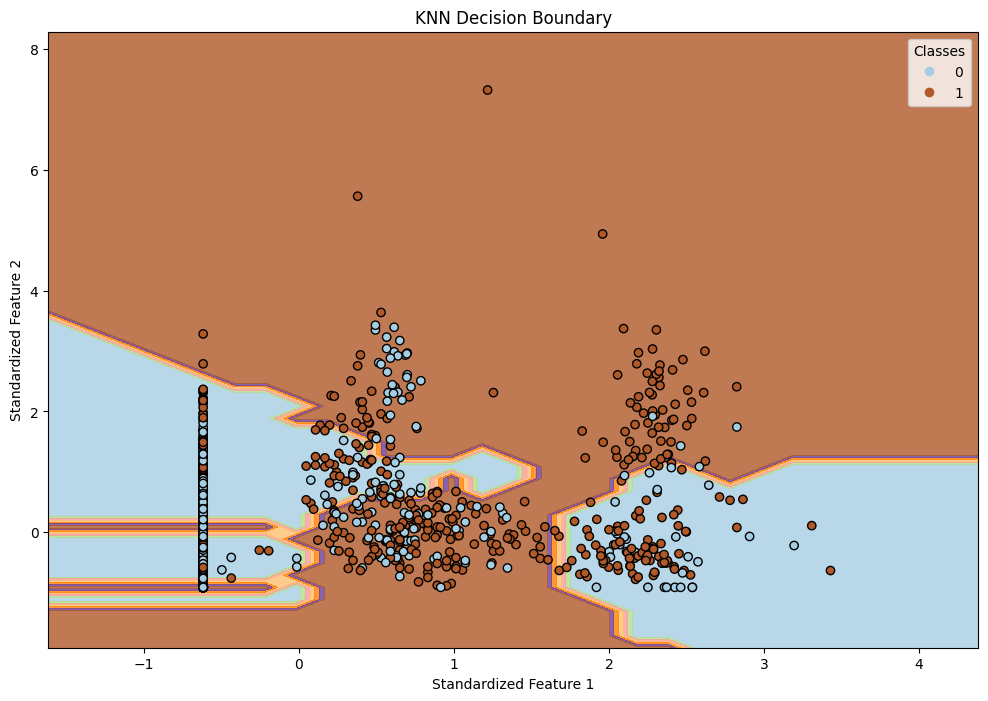


This is the number of users that are depressed using KNN:  1035
This is the number of users that are not depressed using KNN:  475


In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already loaded your dataset into averages_df

# Convert 'depression_class' to numeric (Convert all errors to NAN then NAN turns into 0)
averages_df['depression_class'] = pd.to_numeric(averages_df['depression_class'], errors='coerce').fillna(0)

# Creating the features for the KNN
avg_sleep_values = averages_df['avg_sleep'].values
avg_step_values = averages_df['avg_step'].values
avg_eat_values = averages_df['avg_eat'].values
avg_drink_values = averages_df['avg_drink'].values
avg_care_values = averages_df['avg_care'].values

# Use 'depression_class' column as labels
labels = averages_df['depression_class']

# Reshape the data to a 2D array
features = np.column_stack((avg_sleep_values, avg_step_values, avg_eat_values, avg_drink_values, avg_care_values))

# Standardize the features for better visualization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Create a KNN classifier with hyperparameter tuning
best_knn_classifier = KNeighborsClassifier(n_neighbors=30)  # Adjust the number of neighbors

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.3, random_state=42)

# Train the KNN classifier
best_knn_classifier.fit(X_train, y_train)

# Additional details
print("\nBest KNN Details:")
# Print training accuracy
train_accuracy_knn = best_knn_classifier.score(X_train, y_train)
print("KNN Training Accuracy:", train_accuracy_knn)

# Print testing accuracy
test_accuracy_knn = best_knn_classifier.score(X_test, y_test)
print("KNN Testing Accuracy:", test_accuracy_knn)

# Cross-validation
cv_accuracy = cross_val_score(best_knn_classifier, features_scaled, labels, cv=5)
print("Cross-Validation Accuracy:", np.mean(cv_accuracy))

# Plot the KNN decision boundary with two features
plt.figure(figsize=(12, 8))

# Create meshgrid for all features
h = .2  # Adjust the step size in the mesh
x_min, x_max = features_scaled[:, 0].min() - 1, features_scaled[:, 0].max() + 1
y_min, y_max = features_scaled[:, 1].min() - 1, features_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Use all features for prediction
meshgrid_data = np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel()), np.zeros_like(xx.ravel()), np.zeros_like(xx.ravel())]
Z = best_knn_classifier.predict(meshgrid_data)
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

# Scatter plot with two features
scatter = plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=labels, cmap=plt.cm.Paired, edgecolors='k')

# Add a legend
plt.legend(*scatter.legend_elements(), title="Classes")

plt.title('KNN Decision Boundary')
plt.xlabel('Standardized Feature 1')
plt.ylabel('Standardized Feature 2')  # You may need to adjust the labels based on the number of features
plt.show()

# Print whether each user is depressed or not
depressed_count_knn = 0
n_depressed_count_knn = 0

for index, row in averages_df.iterrows():
    features_test = scaler.transform([[row['avg_sleep'], row['avg_step'], row['avg_eat'], row['avg_drink'], row['avg_care']]])
    prediction_knn = best_knn_classifier.predict(features_test)

    if prediction_knn == 1:
        depressed_count_knn += 1
    else:
        n_depressed_count_knn += 1

print("\nThis is the number of users that are depressed using KNN: ", depressed_count_knn)
print("This is the number of users that are not depressed using KNN: ", n_depressed_count_knn)

